# Parsing Events from Raw Data

This tutorial describes how to read experimental events from raw recordings, and how to convert between the two different representations of events within MNE-Python (Events arrays and Annotations objects).

This notebook describes in more broadly on reading reading experimental events from a `STIM channel` focusing on `events` and `annotations` 

Also coveres reading events that are in a marker file or included in the data file as an embedded array. 


In [8]:
import sys
import os
import numpy as np
import os.path as op
sys.path.append("../")
from mne_path import PathHandler
from glob import glob
import pandas as pd
ph = PathHandler()

import mne

%matplotlib inline

# Read Raw Data

In [2]:
# change to relevant datasets
SAMPLE_DATA_DIR = ph.cddir(ph.SAMPLE_DIR)
TESTING_DATA_DIR = ph.cddir(ph.TESTING_DIR)

# read the raw file
sample_data_raw_file = os.path.join(SAMPLE_DATA_DIR,'MEG',
                                    'sample',
                                    'sample_audvis_raw.fif')

# limit to 60
fif_raw = mne.io.read_raw_fif(sample_data_raw_file)
fif_raw.crop(tmax = 60).load_data()

Changed to:  /Users/jonghang/mne_data/MNE-sample-data
Changed to:  /Users/jonghang/mne_data/MNE-testing-data
Opening raw data file /Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

## The Events and Annotations data structures

Generally speaking, both the Events and `mne.Annotations` data structures serve the same purpose: they provide a mapping between times during an EEG/MEG recording and a description of what happened at those times. In other words, they associate a *when* with a *what*. The main differences are:

1. **Units**: 
   * The Events data structure represents the ***when* in terms of samples**, 
   * The `mne.Annotations` data structure represents the ***when* in seconds**.
2. **Limits on the description**: the Events data structure represents the *what* as an integer "Event ID" code, whereas the `mne.Annotations` data structure represents the *what* as a string.
3. **How duration is encoded**: Events in an Event array do not have a duration (though it is possible to represent duration with pairs of onset/offset events within an Events array), whereas each element of an
   `mne.Annotations` object necessarily includes a duration (though the duration can be zero if an instantaneous event is desired).
4. **Internal representation**: 
   * Events are stored as an ordinary `numpy.darray`,
   * `mne.Annotations` is a `list`-like class defined in MNE-Python

## STIM Channel

* `STIM CHANNEL` is referring to __Stimulus Channel__ 
* This channel that does not receive signals from an EEG, MEG, or other sensor
* Instead, STIM channels record voltages from experiment-controlling computer.  These voltages are usually short, rectangular DC pulses of fixed magnitudes) that can be divided by:
  * __time-locked__ to experimental events, such as the onset of a stimulus or a button-press response by the subject (those pulses are sometimes called `TTL`_ pulses, event pulses, trigger signals, or just "triggers")
  * __Not strictly time-locked__ that may occur in between trials to indicate the type of stimulus (or experimental condition) that is about to occur on the upcoming trial
* In terms of sources of channels:
  * The DC pulses may be all on one STIM channel where different experimental events or trial types are encoded as different voltage magnitudes)
  * Spread across several channels, in which case the channel(s) on which the pulse(s) occur can be used to encode different events or conditions
* Even on systems with multiple STIM channels, there is often one channel that records a weighted sum of the other STIM channels, in such a way that voltage levels on that channel can be unambiguously decoded as particular event types. 
* The `MNE-sample-data` used in this notebook was acquired from an older Neuromag systems where the "summation channel" was typically `STI 014`
* `STI101` is the newer system:

# Plot Pick Type
## `STIM`

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Using matplotlib as 2D backend.


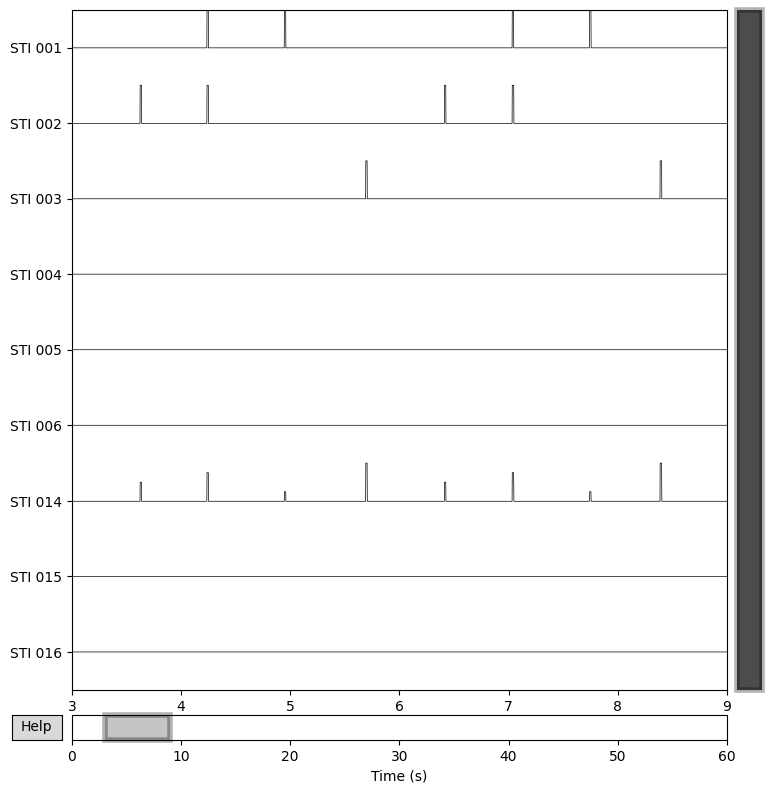

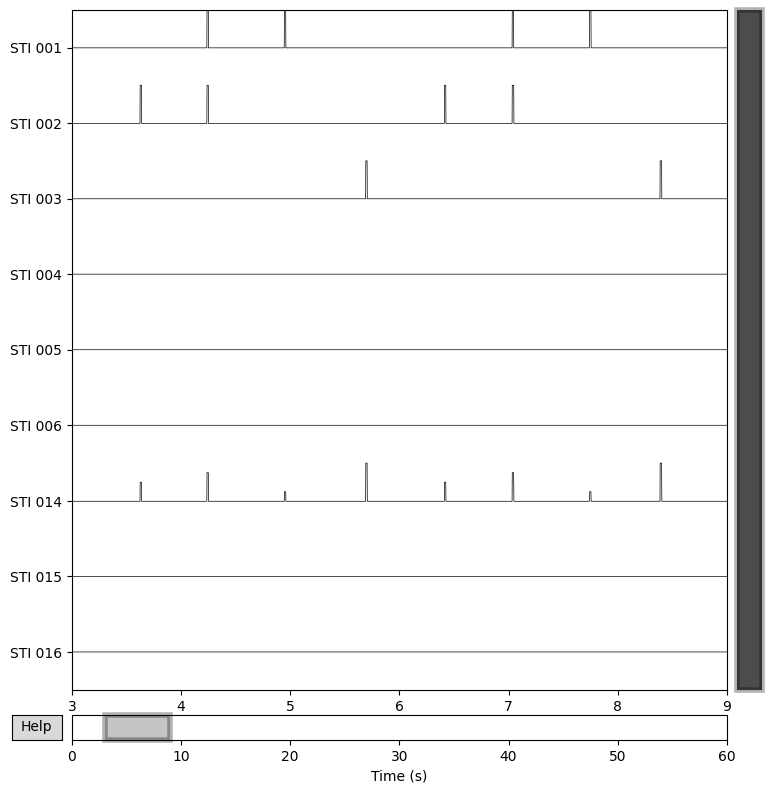

In [3]:
# make a copy of data
plot_fif = fif_raw.copy()

# pick types
picked_fif = plot_fif.pick_types(meg = False, stim = True)
picked_fif.plot(start = 3, duration = 6)

## `MEG`

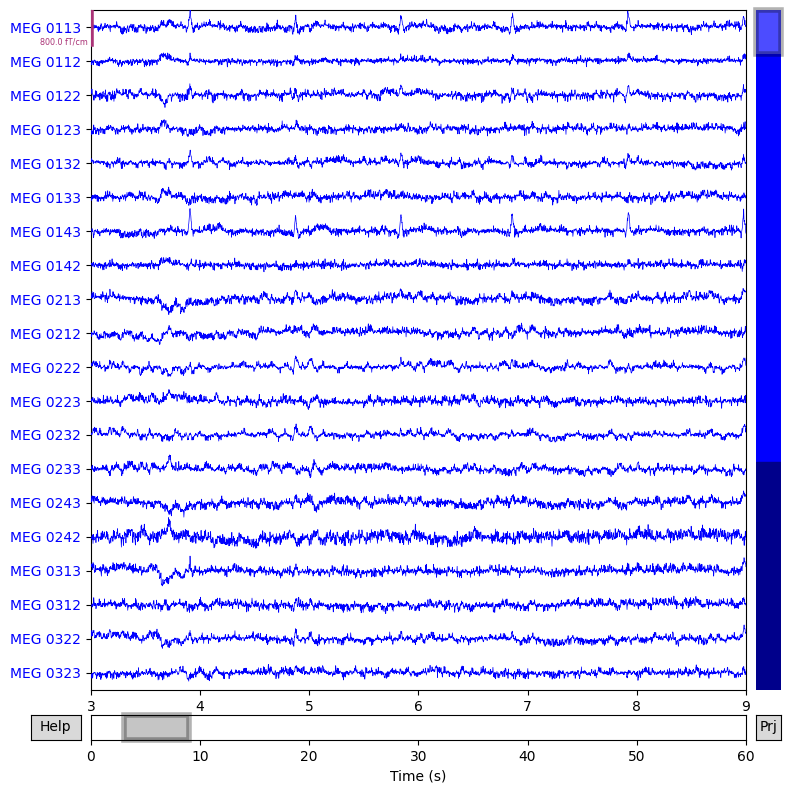

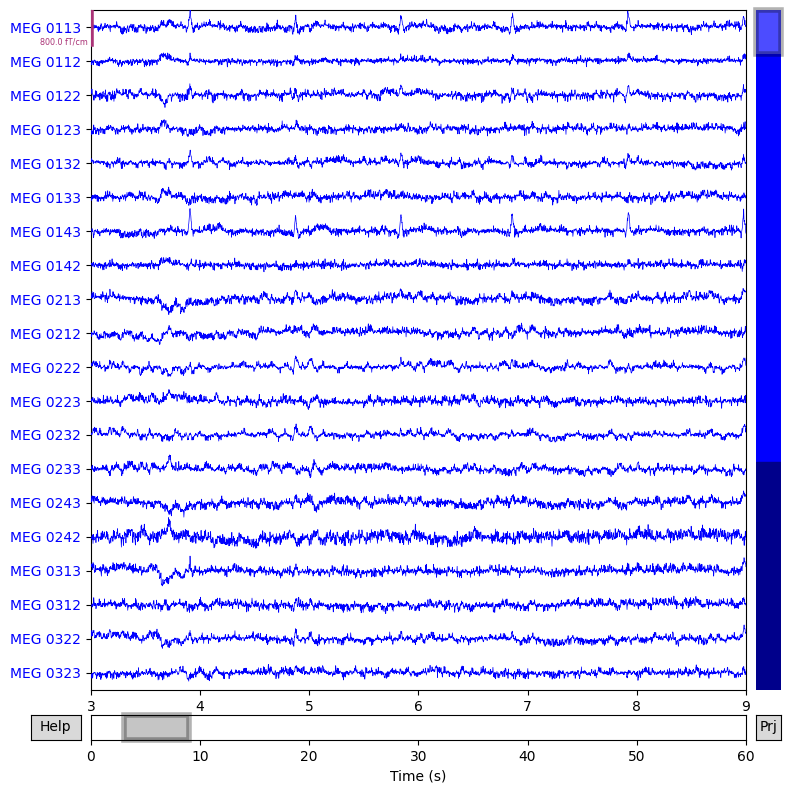

In [4]:
# make a copy of data
plot_fif = fif_raw.copy()

# pick types
picked_fif = plot_fif.pick_types(meg = True, stim = False)
picked_fif.plot(start = 3, duration = 6)

`STI 014` (the summation channel) contains pulses of different magnitudes can be seen above whereas pulses on other channels have consistent magnitudes. You can also see that every time there is a pulse on one of the
other STIM channels, there is a corresponding pulse on `STI 014`.

## Converting a STIM channel signal to an Events array

* Events recorded on a STIM channel can be converted  into an events array using `mne.find_events`
* The sample number of the onset (or offset) of each pulse is recorded as the event time, the pulse magnitudes are converted into integers, and these pairs of sample numbers plus integer codes are stored in `numpy array` (usually called "the events array" or just "the events")
* In its simplest form, the function requires only the `mne.io.Raw` object, and the name of the channel(s) from which to read events

In [10]:
events = mne.find_events(fif_raw, stim_channel = 'STI 014')

# show the first 5
print(events[:5])  

86 events found
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


In [14]:
events_df = pd.DataFrame(events)
events_df.columns = ["EVENT_ID","ONSET","DURATION"]

display(events_df.shape)
display(events_df.head())

(86, 3)

,EVENT_ID,ONSET,DURATION
0,27977,0,2
1,28345,0,3
2,28771,0,1
3,29219,0,4
4,29652,0,2
...,...,...,...
81,59739,0,3
82,60129,0,1
83,60563,0,4
84,61035,0,2


In [15]:
events_df.describe()

,EVENT_ID,ONSET,DURATION
count,86.000000,86.0,86.000000
mean,44818.744186,0.0,3.953488
std,9809.176695,0.0,6.342957
min,27977.000000,0.0,1.000000
25%,36302.250000,0.0,2.000000
50%,44882.000000,0.0,3.000000
75%,53007.250000,0.0,4.000000
max,61458.000000,0.0,32.000000


.. admonition:: The middle column of the Events array
    :class: sidebar note

    MNE-Python events are actually *three* values: in between the sample
    number and the integer event code is a value indicating what the event
    code was on the immediately preceding sample. In practice, that value is
    almost always ``0``, but it can be used to detect the *endpoint* of an
    event whose duration is longer than one sample. See the documentation of
    `~mne.find_events` for more details.

If you don't provide the name of a STIM channel, `mne.find_events` will first look for MNE-Python `config variables <tut-configure-mne>` for variables `MNE_STIM_CHANNEL`, `MNE_STIM_CHANNEL_1`, etc. If those are
not found, channels `STI 014` and `STI101` are tried, followed by the first channel with type "STIM" present in `raw.ch_names`. If you regularlym work with data from several different MEG systems with different STIM channel names, setting the `MNE_STIM_CHANNEL` config variable may not be very
useful, but for researchers whose data is all from a single system it can be a time-saver to configure that variable once and then forget about it.

`mne.find_events` has several options, including options for aligning events to the onset or offset of the STIM channel pulses, setting the minimum pulse duration, and handling of consecutive pulses (with no return to zero between them). For example, you can effectively encode event duration by passing `output='step'` to `mne.find_events`; see the documentation of `~mne.find_events` for details. More information on working with
events arrays (including how to plot, combine, load, and save event arrays) can be found in the tutorial `tut-event-arrays`.


## Reading embedded events as Annotations

Some EEG/MEG systems generate files where events are stored in a separate data array rather than as pulses on one or more STIM channels. For example,the EEGLAB format stores events as a collection of arrays in the :file:`.set` file. When reading those files, MNE-Python will automatically convert the stored events into an `~mne.Annotations` object and store it as the :attr:`~mne.io.Raw.annotations` attribute of the `~mne.io.Raw` object:

In [ ]:
# testing_data_folder = mne.datasets.testing.data_path()
# eeglab_raw_file = testing_data_folder / 'EEGLAB' / 'test_raw.set'

eeglab_raw_file = os.path.join(TESTING_DATA_DIR,"EEGLAB", "test_raw.set")
eeglab_raw = mne.io.read_raw_eeglab(eeglab_raw_file)
print(eeglab_raw.annotations)

The core data within an `~mne.Annotations` object is accessible
through three of its attributes: ``onset``, ``duration``, and
``description``. Here we can see that there were 154 events stored in the
EEGLAB file, they all had a duration of zero seconds, there were two
different types of events, and the first event occurred about 1 second after
the recording began:



In [ ]:
print(len(eeglab_raw.annotations))
print(set(eeglab_raw.annotations.duration))
print(set(eeglab_raw.annotations.description))
print(eeglab_raw.annotations.onset[0])

More information on working with `~mne.Annotations` objects, including
how to add annotations to `~mne.io.Raw` objects interactively, and how
to plot, concatenate, load, save, and export `~mne.Annotations`
objects can be found in the tutorial `tut-annotate-raw`.

## Converting between Events arrays and Annotations Objects

After reading Events successfully, the events `arrays` or `mne.Annotations` object can be converted from either one to another.

* Events array is needed for epoching continuous data, 
* Annotations object automatically omit spans of data if they overlap with certain annotations, making it event-aware
* function `mne.events_from_annotations` is used to convert an `mne.Annotations` object to an Events array. f This function will assign an integer Event ID to each unique element of `raw.annotations.description`, and will return the mapping of descriptions to integer 
* Event IDs along with the derived Event array
* By default, one event will be created at the onset of each annotation, this can be modified via `chunk_duration` parameter of `mne.events_from_annotations` to create equally spaced events within each annotation span (see `chunk-duration`

The following cell shows the direct creation of an Events array of equally-spaced events

In [ ]:
events_from_annot, event_dict = mne.events_from_annotations(eeglab_raw)
print(event_dict)
print(events_from_annot[:5])

If you want to control which integers are mapped to each unique description value, you can pass a `dict` specifying the mapping as the `event_id` parameter of `mne.events_from_annotations`; this `dict` will be returned unmodified as the `event_dict`.

Note that this `event_dict` can be used when creating `mne.Epochs` from `~mne.io.Raw` objects, as demonstrated in the tutorial `tut-epochs-class`.



In [ ]:
custom_mapping = {'rt': 77, 'square': 42}
(events_from_annot,
 event_dict) = mne.events_from_annotations(eeglab_raw, event_id=custom_mapping)
print(event_dict)
print(events_from_annot[:5])

To make the opposite conversion (from an Events array to an `mne.Annotations` object), you can create a mapping from integer Event ID to string descriptions, use `~mne.annotations_from_events` to construct the `mne.Annotations` object, and call the `mne.io.Raw.set_annotations` method to add the annotations to the
`mne.io.Raw` object.

Because the `sample data <sample-dataset>` was recorded on a Neuromag system (where sample numbering starts when the acquisition system is initiated, not when the *recording* is initiated), we also need to pass in
the `orig_time` parameter so that the onsets are properly aligned relative to the start of recording:



In [ ]:
mapping = {1: 'auditory/left', 2: 'auditory/right', 3: 'visual/left',
           4: 'visual/right', 5: 'smiley', 32: 'buttonpress'}
annot_from_events = mne.annotations_from_events(
    events=events, event_desc=mapping, sfreq=raw.info['sfreq'],
    orig_time=raw.info['meas_date'])
raw.set_annotations(annot_from_events)

Now, the annotations will appear automatically when plotting the raw data,
and will be color-coded by their label value:



In [ ]:
raw.plot(start=5, duration=5)


## Making multiple events per annotation

As mentioned above, you can generate equally-spaced events from an
`~mne.Annotations` object using the ``chunk_duration`` parameter of
`~mne.events_from_annotations`. For example, suppose we have an
annotation in our `~mne.io.Raw` object indicating when the subject was
in REM sleep, and we want to perform a resting-state analysis on those spans
of data. We can create an Events array with a series of equally-spaced events
within each "REM" span, and then use those events to generate (potentially
overlapping) epochs that we can analyze further.



In [ ]:
# create the REM annotations
rem_annot = mne.Annotations(onset=[5, 41],
                            duration=[16, 11],
                            description=['REM'] * 2)
raw.set_annotations(rem_annot)
(rem_events,
 rem_event_dict) = mne.events_from_annotations(raw, chunk_duration=1.5)

Now we can check that our events indeed fall in the ranges 5-21 seconds and
41-52 seconds, and are ~1.5 seconds apart (modulo some jitter due to the
sampling frequency). Here are the event times rounded to the nearest
millisecond:



In [ ]:
print(np.round((rem_events[:, 0] - raw.first_samp) / raw.info['sfreq'], 3))